In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle
import catboost


warnings.filterwarnings(action="ignore", category=FutureWarning)

pd.__version__, sklearn.__version__, catboost.__version__

('2.1.1', '1.3.1', '1.2.2')

In [4]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [5]:
consolidated_df = pd.read_parquet(
    f"{SCRATCH_DIR}/top_airline_airport_consolidated_features_2019.parquet"
)

print(consolidated_df.shape)
# (2626181, 36)

consolidated_df.head()

(2626181, 36)


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,year_of_manufacture,...,aircraft_type,aircraft_manufacturer,aircraft_model,DepDel15,ArrDel15,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,1,11,5,0940,1110,90,421,2,2016,...,5,AIRBUS,A320-214,0,0,0,0,0,0,0
1,1,1,11,5,1810,1945,95,421,2,2007,...,5,AIRBUS,A320-214,1,1,0,0,0,0,29
2,1,1,11,5,1915,2150,275,1770,8,2011,...,5,AIRBUS,A320-214,0,0,0,0,0,0,0
3,1,1,11,5,1915,2150,275,1770,8,2011,...,5,AIRBUS,A320-214,0,0,0,0,0,0,0
4,1,1,11,5,1420,1640,140,763,4,2011,...,5,AIRBUS,A320-214,0,0,0,0,0,0,0


In [5]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "year_of_manufacture",
    "num_seats",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "company_type",
    "registrant",
    "aircraft_usage",
    "engine_type",
    "registration_status",
    "engine_manufacturer",
    "engine_model",
    "aircraft_type",
    "aircraft_manufacturer",
    "aircraft_model",
]

delay_cols = [
    "DepDel15",
    "ArrDel15",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]

In [6]:
df = consolidated_df.copy()

# Choose preferred delay type and convert the label to "delayed"
df["delayed"] = (df["DepDel15"].eq(1)) | (df["ArrDel15"].eq(1))
df = df.drop(delay_cols, axis="columns")

df = df.reset_index(drop=True)

print(df.value_counts("delayed"))
# delayed
# False    2006414
# True      619767

print(df.shape)
# (2626181, 30)

df.head()

delayed
False    2006414
True      619767
Name: count, dtype: int64
(2626181, 30)


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,year_of_manufacture,...,registrant,aircraft_usage,engine_type,registration_status,engine_manufacturer,engine_model,aircraft_type,aircraft_manufacturer,aircraft_model,delayed
0,1,1,11,5,0940,1110,90,421,2,2016,...,other,1T,5,V,CFM,CFM56-5B4/3,5,AIRBUS,A320-214,False
1,1,1,11,5,1810,1945,95,421,2,2007,...,WELLS FARGO TRUST CO NA TRUSTEE,1T,5,V,CFM,CFM56-5B4/P,5,AIRBUS,A320-214,True
2,1,1,11,5,1915,2150,275,1770,8,2011,...,BANK OF UTAH TRUSTEE,1T,5,V,CFM,CFM56-5B4,5,AIRBUS,A320-214,False
3,1,1,11,5,1915,2150,275,1770,8,2011,...,BANK OF UTAH TRUSTEE,1T,5,V,CFM,CFM56-5B4,5,AIRBUS,A320-214,False
4,1,1,11,5,1420,1640,140,763,4,2011,...,WELLS FARGO TRUST CO NA TRUSTEE,1T,5,V,CFM,CFM56-5B4,5,AIRBUS,A320-214,False


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split


# CatBoost is converting True/False into string values for some reason
# casting the labels as 1/0 ints here
X = df.drop("delayed", axis=1)
y = df["delayed"].astype(int)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
from catboost import CatBoostClassifier


MODEL = "20_all_delays_catboost_tuned_3"

model = CatBoostClassifier(
    eval_metric="Logloss",
    auto_class_weights="Balanced",
    random_state=42,
    early_stopping_rounds=20,
    depth=6,
    l2_leaf_reg=1
)

start_time = time.time()

with open(f"{SCRATCH_DIR}/{MODEL}_grid_search_stdout.log", "w") as log_stdout:
    grid_search_results = model.grid_search(
        param_grid={
            "learning_rate": [0.01, 0.1, 0.6, 1],
            "depth": [4, 6],
            "l2_leaf_reg": [1, 3, 5],
        },
        X=X_train,
        y=y_train,
        cv=3,
        partition_random_seed=42,
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True,
        shuffle=True,
        stratified=True,
        train_size=0.8,
        verbose=100,
        plot=False,
        log_cout=log_stdout
    )

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

TBB Warning: The number of workers is currently limited to 7. The request for 35 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Elapsed time: 4499.4960 seconds


In [9]:
# Checkpoint
with open(f"{SCRATCH_DIR}/{MODEL}_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open(f"{SCRATCH_DIR}/{MODEL}_grid_search_results.pkl", "wb") as f:
    pickle.dump(grid_search_results, f)

# So we can recompute the metrics later
with open(f"{SCRATCH_DIR}/{MODEL}_X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open(f"{SCRATCH_DIR}/{MODEL}_y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

# Just in case
with open(f"{SCRATCH_DIR}/{MODEL}_X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open(f"{SCRATCH_DIR}/{MODEL}_y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

# Model Evaluation


In [10]:
model.get_params()

{'depth': 6,
 'l2_leaf_reg': 5,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'Logloss',
 'random_state': 42,
 'early_stopping_rounds': 20,
 'learning_rate': 0.6}

In [11]:
print(model.evals_result_)

print(model.best_score_)

print(model.best_iteration_)

feature_importance = list(zip(num_cols + cat_cols, model.feature_importances_))

sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

{'learn': {'Logloss': [0.6700107298573477, 0.6631464992868817, 0.6589835150125699, 0.6567459419469643, 0.6555898147717729, 0.6519964752993656, 0.650076294956346, 0.6490951213177072, 0.6473881325166073, 0.6458584212700788, 0.6452341790794254, 0.6445044045689893, 0.6440957290423353, 0.6430748657996403, 0.6421794034056418, 0.6415928784456372, 0.6404910420348279, 0.6399165265291913, 0.6394318884659415, 0.6390791366000993, 0.6387988101397641, 0.6385083857603001, 0.6381341044835573, 0.6375291479921679, 0.6364915968399838, 0.6361594399107815, 0.6356422960143558, 0.6350146322851328, 0.6343843342632342, 0.6340828190857393, 0.6336196921819396, 0.6332153665842994, 0.6327488631621744, 0.6323460232325974, 0.6321302655367503, 0.6318645268523442, 0.6312305371704099, 0.6310009047219631, 0.6305715989725319, 0.6300295917335978, 0.6298654649574269, 0.6296918863634716, 0.6294047192595238, 0.6291357159990214, 0.6289142382986167, 0.628667361879825, 0.6283642831614119, 0.628137603797641, 0.6279208751246325, 

[('DayofMonth', 18.731770512994512),
 ('Month', 17.765595122370037),
 ('DayOfWeek', 8.451597752369283),
 ('CRSDepTime', 7.802390202721108),
 ('Origin_LONGITUDE', 5.884579717812467),
 ('Reporting_Airline', 5.2052893410429695),
 ('Dest_LONGITUDE', 4.832896781274756),
 ('CRSArrTime', 4.317155925736314),
 ('Origin_LATITUDE', 3.6464065690117757),
 ('Quarter', 2.9810129617673047),
 ('CRSElapsedTime', 2.7767277514831292),
 ('Dest_LATITUDE', 2.4248236985320144),
 ('Origin', 2.4246937242253233),
 ('Distance', 2.376477056440156),
 ('Dest', 2.0555211084397977),
 ('Tail_Number', 1.9867671328912058),
 ('aircraft_model', 1.5336263832989747),
 ('year_of_manufacture', 1.4116681158712918),
 ('engine_model', 1.1736401431234493),
 ('registrant', 0.976532534972255),
 ('num_seats', 0.31422034495474094),
 ('engine_manufacturer', 0.21060763972238583),
 ('aircraft_manufacturer', 0.177044683552087),
 ('aircraft_type', 0.15561787309545913),
 ('DistanceGroup', 0.13191513412090028),
 ('registration_status', 0.070

In [12]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)

TITLE = "2019 All Delays (CatBoost)"

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

[[275188 126095]
 [ 41413  82541]]


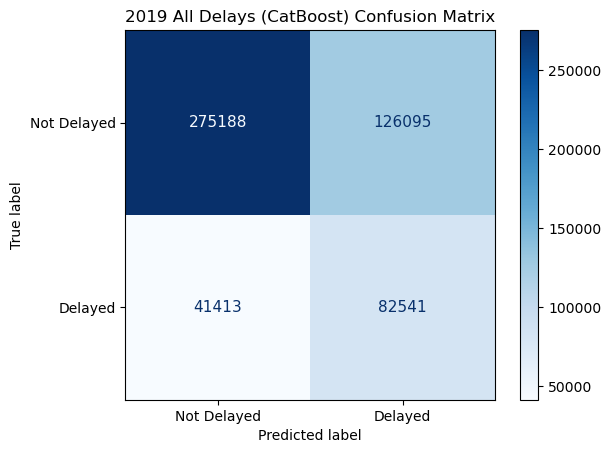

In [13]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title(f"{TITLE} Confusion Matrix")

ax = plt.gca()
for i in range(len(cm)):
    for j in range(len(cm[i])):
        text = ax.texts[i * len(cm) + j]
        text.set_text(str(cm[i][j]))
        text.set_size(11)

plt.savefig(f"visualizations/{MODEL}_cm.png")

plt.show()

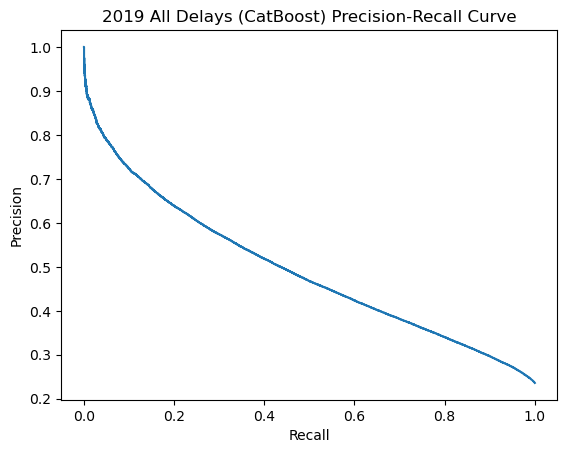

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{TITLE} Precision-Recall Curve")

plt.savefig(f"visualizations/{MODEL}_pr.png")

plt.show()

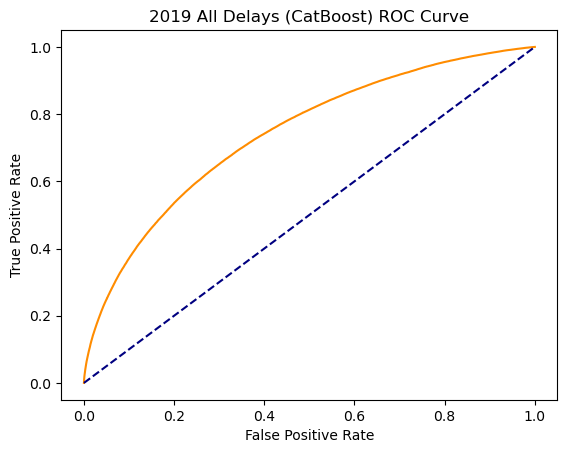

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{TITLE} ROC Curve")

plt.savefig(f"visualizations/{MODEL}_roc.png")

plt.show()

In [16]:
model.best_score_["learn"]["Logloss"]

0.577325545178246

In [17]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr"),
    "Log Loss": model.best_score_["learn"]["Logloss"]
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y(
        "Metric:N", axis=alt.Axis(title="Metric"), sort=df_metrics["Metric"].values
    ),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title=f"{TITLE} Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart.save(f"visualizations/{MODEL}_metrics.png")

chart

alt.LayerChart(...)

In [18]:
# !pip install vl-convert-python